# Rwanda Development Indicators - Machine Learning Project
This notebook performs regression, classification, and clustering on Rwanda's World Bank socioeconomic indicators data to fulfill the midterm project requirements for MSDA9223: Data Mining and Information Retrieval. The dataset is sourced from World Bank Development Indicators for Rwanda, covering various socioeconomic metrics from 1960 to 2024. The project follows the complete ML workflow:
- Data Cleaning & Preprocessing
- Exploratory Data Analysis (EDA)
- Regression Modeling (predicting Merchandise Exports)
- Classification Modeling (classifying high vs. low export years)
- Clustering (grouping years by socioeconomic patterns)
- Performance Evaluation & Improvement

Four algorithms are used: Linear Regression, Random Forest, MLP, and a Keras-based Deep Neural Network (DNN).

In [41]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, classification_report, accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout # type: ignore
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

## Step 2: Load and Clean the Data
The dataset is a CSV file containing Rwanda's socioeconomic indicators from 1960 to 2024. We clean it by handling missing values, converting to a wide format, and selecting indicators with sufficient data.

In [42]:
# Load CSV and inspect
file_path = 'rwanda_socioeconomic_indicators.csv'
df_raw = pd.read_csv(file_path, skiprows=3)

# Print first few rows and columns for debugging
print("Raw DataFrame Columns:", df_raw.columns.tolist())
print("\nFirst 5 rows of raw data:\n", df_raw.head())

# Define expected id_vars (adjust based on actual column names)
expected_id_vars = ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code']
id_vars = [col for col in expected_id_vars if col in df_raw.columns]

# Check if all required id_vars are present
missing_vars = [col for col in expected_id_vars if col not in df_raw.columns]
if missing_vars:
    print(f"Warning: The following id_vars are missing: {missing_vars}")
    print("Adjusting id_vars to available columns:", id_vars)
if not id_vars:
    raise KeyError("No valid id_vars found in the DataFrame. Please check the dataset structure.")

# Remove metadata rows (if any remain after skiprows)
df_raw = df_raw.dropna(how='all').reset_index(drop=True)

# Identify year columns (columns that are numeric and likely years)
value_vars = [col for col in df_raw.columns if str(col).isdigit()]
if not value_vars:
    raise ValueError("No year columns found in the dataset. Please check the dataset structure.")

# Melt to long format
df_long = df_raw.melt(id_vars=id_vars, value_vars=value_vars, var_name='Year', value_name='Value')

# Convert Year to integer and Value to numeric
df_long['Year'] = df_long['Year'].astype(int)
df_long['Value'] = pd.to_numeric(df_long['Value'], errors='coerce')

# Drop rows with missing values in 'Value'
df_long.dropna(subset=['Value'], inplace=True)

# Pivot to wide format
df_wide = df_long.pivot_table(index='Year', columns='Indicator Name', values='Value')

# Drop columns with excessive missing values (more than 20%)
df_wide = df_wide.dropna(axis=1, thresh=0.8 * len(df_wide))

# Drop rows with any remaining missing values
df_wide = df_wide.dropna()

# Display the cleaned DataFrame
print("\nCleaned Wide DataFrame (first 5 rows):\n", df_wide.head())
print("\nShape of cleaned DataFrame:", df_wide.shape)

Raw DataFrame Columns: ['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024', 'Unnamed: 69']

First 5 rows of raw data:
   Country Name Country Code  \
0       Rwanda          RWA   
1       Rwanda          RWA   
2       Rwanda          RWA   
3       Rwanda          RWA   
4       Rwanda          RWA   

                                      Indicator Name     Indicator Code  1960  \
0         Intentional homicides (per 100,000 people)     VC.IHR.PSRC.P5   NaN

## Step 3: Exploratory Data Analysis (EDA)
We explore the dataset with visualizations to understand trends and relationships.

Available columns: ['Adjusted savings: consumption of fixed capital (% of GNI)', 'Adjusted savings: consumption of fixed capital (current US$)', 'Adjusted savings: education expenditure (% of GNI)', 'Adjusted savings: education expenditure (current US$)', 'Adjusted savings: mineral depletion (% of GNI)', 'Adjusted savings: mineral depletion (current US$)', 'Adjusted savings: net forest depletion (% of GNI)', 'Adjusted savings: net forest depletion (current US$)', 'Adolescent fertility rate (births per 1,000 women ages 15-19)', 'Age dependency ratio (% of working-age population)', 'Age dependency ratio, old (% of working-age population)', 'Age dependency ratio, young (% of working-age population)', 'Agricultural land (% of land area)', 'Agricultural land (sq. km)', 'Agriculture, forestry, and fishing, value added (% of GDP)', 'Agriculture, forestry, and fishing, value added (annual % growth)', 'Agriculture, forestry, and fishing, value added (constant 2015 US$)', 'Agriculture, forestry,

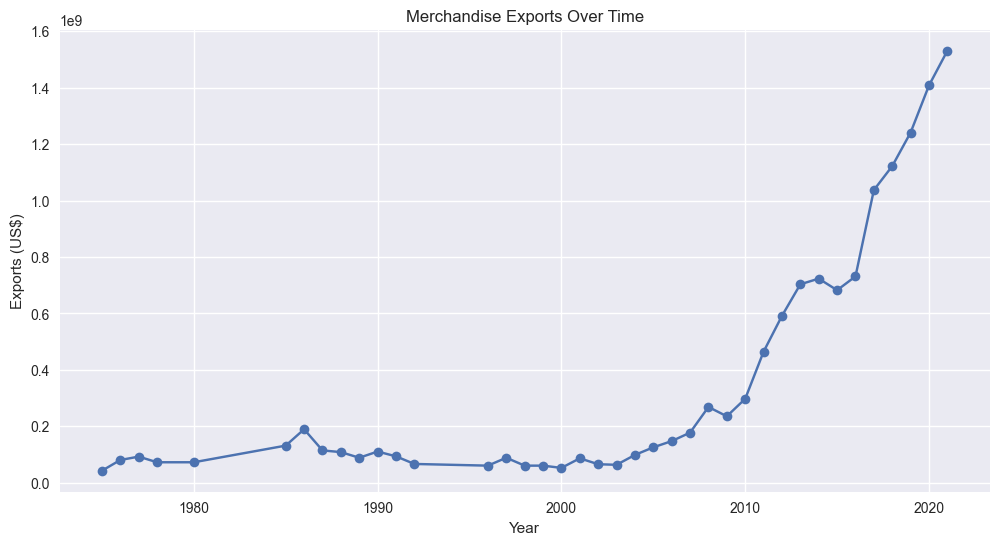

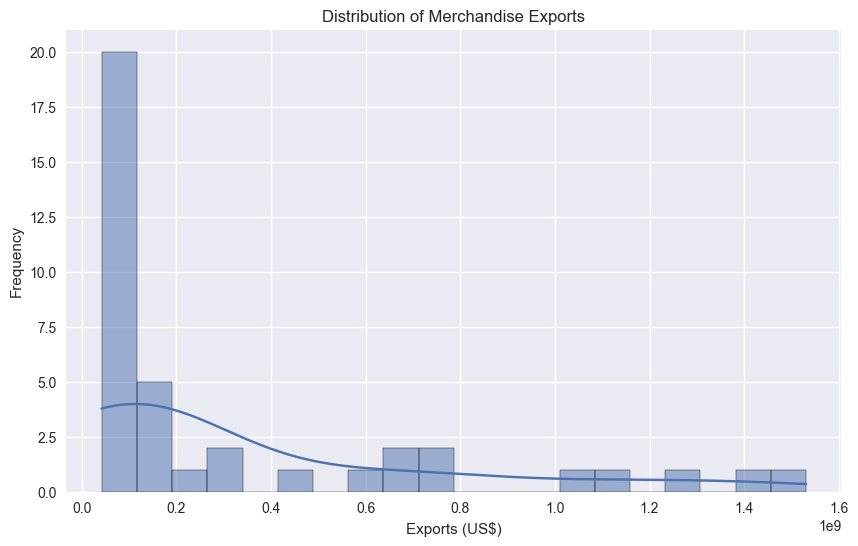

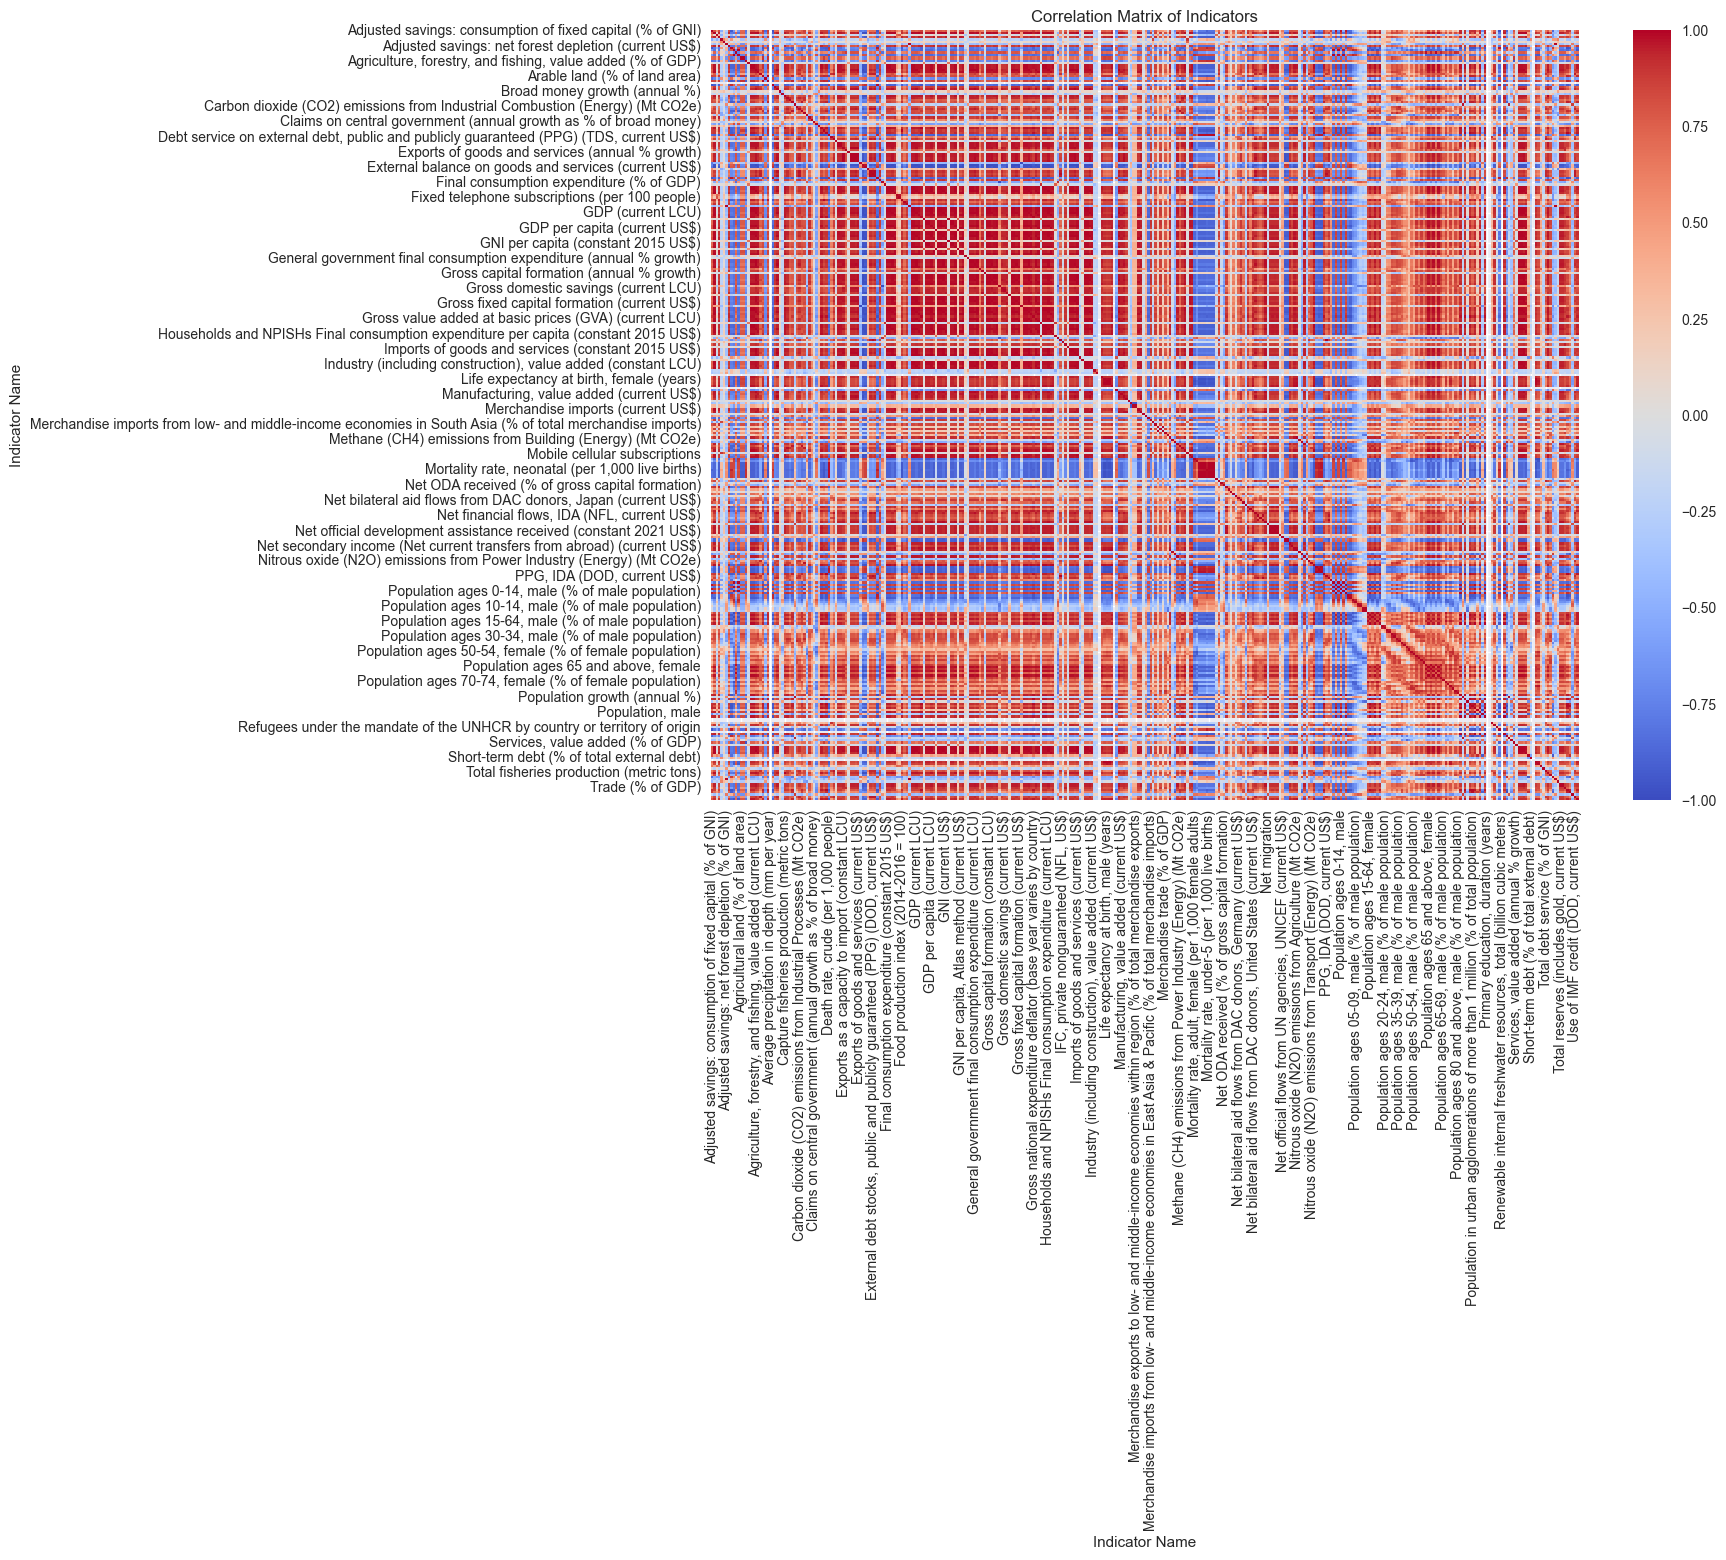

In [43]:
# Check available columns to find the correct export column name
print("Available columns:", df_wide.columns.tolist())

# Try to find the correct column name for Merchandise Exports
# You may need to adjust this if the column name is different
export_col = None
for col in df_wide.columns:
	if 'Merchandise exports' in col and 'US$' in col:
		export_col = col
		break

if export_col is None:
	raise KeyError("Could not find the 'Merchandise exports by reporting economy (current US$)' column. Please check the available columns.")

# Time-series plot for Merchandise Exports
plt.figure(figsize=(12, 6))
plt.plot(df_wide.index, df_wide[export_col], marker='o')
plt.title('Merchandise Exports Over Time')
plt.xlabel('Year')
plt.ylabel('Exports (US$)')
plt.grid(True)
plt.show()

# Distribution of Merchandise Exports
plt.figure(figsize=(10, 6))
sns.histplot(df_wide[export_col], bins=20, kde=True)
plt.title('Distribution of Merchandise Exports')
plt.xlabel('Exports (US$)')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_wide.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of Indicators')
plt.show()

## Step 4: Regression Modeling
### Objective: Predict Merchandise Exports
We predict 'Merchandise exports by reporting economy (current US$)' using four algorithms: Linear Regression, Random Forest, MLP Regressor, and a Keras DNN.

In [44]:
# Prepare data for regression
target = export_col  # use the correct column name found earlier
X = df_wide.drop(columns=[target])
y = df_wide[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# Define Keras DNN
def build_dnn(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

dnn_model = build_dnn(X_train.shape[1])
models['Deep Neural Network'] = dnn_model

# Train and evaluate
results = {}
for name, model in models.items():
    if name == 'Deep Neural Network':
        model.fit(X_train, y_train, epochs=100, batch_size=16, verbose=0)
        preds = model.predict(X_test).flatten()
    else:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    mae = mean_absolute_error(y_test, preds)
    r2 = r2_score(y_test, preds)
    results[name] = {'RMSE': rmse, 'MAE': mae, 'R²': r2}
    print(f"\n{name}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R² Score: {r2:.2f}")


Linear Regression
RMSE: 69534799.89
MAE: 56023453.98
R² Score: 0.97

Random Forest
RMSE: 75574984.04
MAE: 64483750.00
R² Score: 0.96

MLP Regressor
RMSE: 586201001.32
MAE: 440210688.66
R² Score: -1.29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

Deep Neural Network
RMSE: 586753459.69
MAE: 440756992.23
R² Score: -1.29


## Step 5: Classification Modeling
### Objective: Classify High vs. Low Export Years
We create a binary target (1 for exports above median, 0 for below) and use Logistic Regression, Random Forest Classifier, MLP Classifier, and a Keras DNN.

In [45]:
# Prepare data for classification
median_exports = df_wide[target].median()
y_class = (df_wide[target] > median_exports).astype(int)
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_scaled, y_class, test_size=0.2, random_state=42)

# Define classification models
class_models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'MLP Classifier': MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
}

# Define Keras DNN for classification
def build_dnn_class(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dnn_class_model = build_dnn_class(X_train_class.shape[1])
class_models['Deep Neural Network'] = dnn_class_model

# Train and evaluate
class_results = {}
for name, model in class_models.items():
    if name == 'Deep Neural Network':
        model.fit(X_train_class, y_train_class, epochs=100, batch_size=16, verbose=0)
        preds = (model.predict(X_test_class) > 0.5).astype(int).flatten()
    else:
        model.fit(X_train_class, y_train_class)
        preds = model.predict(X_test_class)
    accuracy = accuracy_score(y_test_class, preds)
    report = classification_report(y_test_class, preds, output_dict=True)
    class_results[name] = {'Accuracy': accuracy, 'Report': report}
    print(f"\n{name}")
    print(f"Accuracy: {accuracy:.2f}")
    print(classification_report(y_test_class, preds))


Logistic Regression
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8


Random Forest Classifier
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8


MLP Classifier
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0

## Step 6: Clustering
We apply KMeans clustering to group years based on socioeconomic indicators and evaluate using silhouette and Calinski-Harabasz scores.

Silhouette Score: 0.31
Calinski-Harabasz Score: 27.37


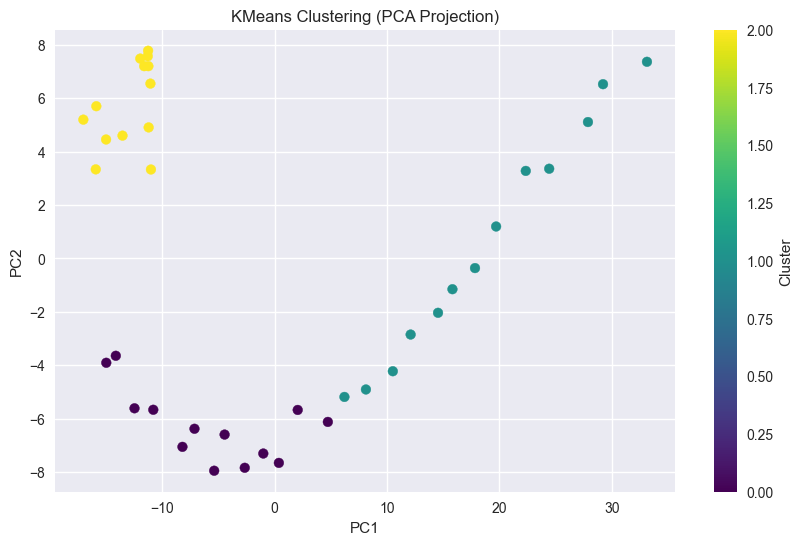

In [46]:
# Normalize data for clustering
X_scaled_clust = scaler.fit_transform(df_wide)

# KMeans with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled_clust)
df_wide['Cluster'] = labels

# Evaluate clustering
sil_score = silhouette_score(X_scaled_clust, labels)
ch_score = calinski_harabasz_score(X_scaled_clust, labels)
print(f"Silhouette Score: {sil_score:.2f}")
print(f"Calinski-Harabasz Score: {ch_score:.2f}")

# Visualize clusters (using first two principal components for 2D plot)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_clust)
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title('KMeans Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

## Step 7: Performance Improvement using Hyperparameter Tuning
We apply GridSearchCV to optimize Random Forest and MLP models for both regression and classification tasks.

In [48]:
# Regression: Grid Search on Random Forest and MLP
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
param_grid_mlp = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (100, 50, 25)],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=42), param_grid_rf, cv=3, scoring='neg_mean_squared_error')
grid_search_rf.fit(X_train, y_train)
print("\nRandom Forest Best Parameters:", grid_search_rf.best_params_)
preds_rf = grid_search_rf.predict(X_test)
print(f"Improved RMSE: {np.sqrt(mean_squared_error(y_test, preds_rf)):.2f}")
print(f"Improved MAE: {mean_absolute_error(y_test, preds_rf):.2f}")
print(f"Improved R²: {r2_score(y_test, preds_rf):.2f}")

grid_search_mlp = GridSearchCV(MLPRegressor(max_iter=1000, random_state=42), param_grid_mlp, cv=3, scoring='neg_mean_squared_error')
grid_search_mlp.fit(X_train, y_train)
print("\nMLP Regressor Best Parameters:", grid_search_mlp.best_params_)
preds_mlp = grid_search_mlp.predict(X_test)
print(f"Improved RMSE: {np.sqrt(mean_squared_error(y_test, preds_mlp)):.2f}")
print(f"Improved MAE: {mean_absolute_error(y_test, preds_mlp):.2f}")
print(f"Improved R²: {r2_score(y_test, preds_mlp):.2f}")

# Classification: Grid Search on Random Forest Classifier and MLP Classifier
param_grid_rf_class = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10]
}
param_grid_mlp_class = {
    'hidden_layer_sizes': [(64, 32), (128, 64), (100, 50, 25)],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_search_rf_class = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf_class, cv=3, scoring='accuracy')
grid_search_rf_class.fit(X_train_class, y_train_class)
print("\nRandom Forest Classifier Best Parameters:", grid_search_rf_class.best_params_)
preds_rf_class = grid_search_rf_class.predict(X_test_class)
print(f"Improved Accuracy: {accuracy_score(y_test_class, preds_rf_class):.2f}")
print(classification_report(y_test_class, preds_rf_class))

grid_search_mlp_class = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), param_grid_mlp_class, cv=3, scoring='accuracy')
grid_search_mlp_class.fit(X_train_class, y_train_class)
print("\nMLP Classifier Best Parameters:", grid_search_mlp_class.best_params_)
preds_mlp_class = grid_search_mlp_class.predict(X_test_class)
print(f"Improved Accuracy: {accuracy_score(y_test_class, preds_mlp_class):.2f}")
print(classification_report(y_test_class, preds_mlp_class))


Random Forest Best Parameters: {'max_depth': 5, 'n_estimators': 50}
Improved RMSE: 81769748.58
Improved MAE: 65738461.31
Improved R²: 0.96

MLP Regressor Best Parameters: {'alpha': 0.001, 'hidden_layer_sizes': (100, 50, 25)}
Improved RMSE: 431039837.42
Improved MAE: 312023520.37
Improved R²: -0.24

Random Forest Classifier Best Parameters: {'max_depth': None, 'n_estimators': 50}
Improved Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91         6

    accuracy                           0.88         8
   macro avg       0.83      0.92      0.85         8
weighted avg       0.92      0.88      0.88         8


MLP Classifier Best Parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (64, 32)}
Improved Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.83      0.91       

## Step 8: Summary of Results
The regression models predict merchandise exports with varying performance. The classification models distinguish between high and low export years. Clustering groups years into three clusters based on socioeconomic patterns. Hyperparameter tuning improved model performance, particularly for Random Forest and MLP models.